# GAN 
## (cDCGAN, conditional Deep Convolutional Generative Adversarial Networks)

## 0. Import libraries

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv

from tensorflow.keras.layers import Activation, BatchNormalization, Concatenate, Dense, multiply
from tensorflow.keras.layers import Embedding, Flatten, Input, Multiply, Reshape,  MaxPooling2D, LeakyReLU, Dropout, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

from keras.models import Sequential, Model, load_model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras import losses
from tensorflow.keras.utils import to_categorical
import keras.backend as K
from tensorflow.keras.utils import plot_model
from __future__ import print_function, division

from sklearn.preprocessing import MinMaxScaler

## 1. Load dataset

In [5]:
d = pd.read_csv('/home/sbml/cgan/230306_data/padding/cgan_train_module.csv')[['resized_scaled','pack_soh']]
d_n = pd.read_csv('/home/sbml/cgan/230306_data/padding/cgan_train_module_noise.csv')[['resized_scaled','pack_soh']]

In [6]:
df = pd.concat([d, d_n])
X = [eval(i) for i in df['resized_scaled'].tolist()]
X = np.array(X)
y = np.array(df['pack_soh'].tolist()) 

In [7]:
label = y
label_l = []
for cnt in range(len(label)):
    i = label[cnt]
    if i>=0.99 : 
        lab = '1~'
        num = 0
    elif 0.98<=i<0.99 :
        lab = '0.98~0.99'
        num = 1
    elif 0.97<=i<0.98 :
        lab = '0.97~0.98'
        num = 2
    elif 0.96<=i<0.97 :
        lab = '0.96~0.97'
        num = 3
    elif 0.95<=i<0.96 :
        lab = '0.95~0.96'
        num = 4
    elif 0.94<=i<0.95 :
        lab = '0.94~0.95'
        num = 5
    elif 0.93<=i<0.94 :
        lab = '0.93~0.94'
        num = 6
    elif 0.92<=i<0.93 :
        lab = '0.92~0.93'
        num = 7
    elif 0.91<=i<0.92 :
        lab = '0.91~0.92'
        num = 8
    elif 0.90<=i<0.91 :
        lab = '0.90~0.91'
        num = 9      

    label_l.append(num)
label_l

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 1,
 0,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 3,
 3,
 4,
 4,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 4,
 4,
 4,
 4,
 4,
 5,
 4,
 4,
 4,
 4,
 5,
 4,
 4,
 4,
 4,
 5,
 4,
 5,
 5,
 5,
 5,
 5,
 6,
 5,
 6,
 5,
 6,
 6,
 5,
 5,
 6,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 7,
 8,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


## 2. cDCGAN

In [8]:
img_rows = 14
img_cols = 256
channels = 3
z_dim = 100
num_classes = 10

img_shape = (img_rows, img_cols, channels)

In [10]:
def build_generator(z_dim):
    
    model = Sequential()

    model.add(Dense(256 * 32 * 7, input_dim=  z_dim ))
    model.add(Reshape((7, 32, 256)))

    model.add(Conv2DTranspose(128, kernel_size=3, strides=(2,2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    

    model.add(Conv2DTranspose(64, kernel_size=3, strides=(1,2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    

    model.add(Conv2DTranspose(3, kernel_size=3, strides=(1,2), padding='same'))
    model.add(Activation('tanh'))
    
    model.summary()

    return model

In [11]:
build_generator(z_dim)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 57344)             5791744   
                                                                 
 reshape (Reshape)           (None, 7, 32, 256)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 64, 128)      295040    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 14, 64, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 64, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 128, 64)      7

In [14]:
def build_cgan_generator(z_dim):

    z = Input(shape=(z_dim, ))
    
    label = Input(shape=(1, ), dtype='int32')
    label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)
    label_embedding = Flatten()(label_embedding)

    joined_representation = Concatenate()([z, label_embedding])
    print(joined_representation.shape)
    
    generator = build_generator(z_dim*2)
    conditioned_img = generator(joined_representation)

    return Model([z, label], conditioned_img)

In [15]:
build_cgan_generator(z_dim)

(None, 200)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 57344)             11526144  
                                                                 
 reshape_2 (Reshape)         (None, 7, 32, 256)        0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 14, 64, 128)      295040    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 14, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 64, 128)       0         
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 14, 1

In [16]:
def build_discriminator(img_shape):

    model = Sequential()
    
    model.add( Conv2D(64, kernel_size=3,  strides=2, input_shape=(img_shape[0], img_shape[1], img_shape[2]+1), padding='same')) # [2]+1
    model.add(LeakyReLU(alpha=0.2))    
    model.add( Conv2D(64, kernel_size=3,  strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))       
    model.add( Conv2D(128, kernel_size=3,  strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))  
    model.add(Flatten())
    model.add(Dense(256))#, activation='sigmoid'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.summary()  
    
    return model

In [17]:
build_discriminator(img_shape)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 128, 64)        2368      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 7, 128, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 64, 64)         36928     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 4, 64, 64)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 32, 128)        73856     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 2, 32, 128)        0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)             

In [18]:
def build_cgan_discriminator(img_shape):

    img = Input(shape=img_shape)
    label = Input(shape=(1, ), dtype='int32')
    label_embedding = Embedding(num_classes, 14*256*1,input_length=1)(label)   # 14*256*1 -> concat
    label_embedding = Flatten()(label_embedding)
    label_embedding = Reshape((14,256,1))(label_embedding)
    concatenated = Concatenate(axis=-1)([img, label_embedding])
    
    discriminator = build_discriminator(img_shape)
    classification = discriminator(concatenated)

    return Model([img, label], classification)

In [19]:
build_cgan_discriminator(img_shape)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 7, 128, 64)        2368      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 7, 128, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 64, 64)         36928     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 4, 64, 64)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 32, 128)        73856     
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 2, 32, 128)        0         
                                                                 
 flatten_4 (Flatten)         (None, 8192)             

In [20]:
def build_cgan(generator, discriminator):

    z = Input(shape=(z_dim, ))
    label = Input(shape=(1, ))
    img = generator([z, label])

    classification = discriminator([img, label])
    model = Model([z, label], classification)

    return model

In [22]:
def sample_images(image_grid_rows=2, image_grid_columns=5):

    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    labels = np.arange(0, 10).reshape(-1, 1)
    

    gen_imgs = generator.predict([z, labels])
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt])
            axs[i, j].axis('off')
            axs[i, j].set_title("SOH label: %d" % labels[cnt])
            cnt += 1
    return gen_imgs

In [23]:
def save_images(a):

    z = np.random.normal(0, 1, (1, z_dim))
    labels = np.arange(a, a+1).reshape(-1, 1)
    gen_imgs = generator.predict([z, labels])
    gen_imgs = 0.5 * gen_imgs + 0.5

    for k in range(14):
        target = gen_imgs[0][k].reshape(1,256,3)
        target = np.resize(target, (100,256,3))

        plt.imshow(target)    
        #plt.savefig('/home/sbml/cgan/230306_data/figure/img_result/test3/soh' + str(a) + '_module' + str(k) + '.svg')
        plt.show()
    return gen_imgs

In [24]:
accuracies = []
losses = []
def train( X_train, y_train, iterations, batch_size, sample_interval):


    X_train = X_train / 127.5 - 1.
    y_train = y_train.reshape(-1, 1)
    

    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]

        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict([z, labels])

        d_loss_real = discriminator.train_on_batch([imgs, labels], real)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        

        z = np.random.normal(0, 1, (batch_size, z_dim))
        labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        g_loss = cgan.train_on_batch([z, labels], real)

        if (iteration + 1) % sample_interval == 0:

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss[0], 100 * d_loss[1], g_loss))

            losses.append((d_loss[0], g_loss))
            accuracies.append(100 * d_loss[1])

            sample_images()
    for a in [0,1,2,3,4,5,6,7,8,9]:
        save_images(a)

In [52]:
discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(learning_rate=0.0002),
                      metrics=['accuracy'])

generator = build_cgan_generator(z_dim)

discriminator.trainable = False


cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 7, 128, 64)        2368      
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 7, 128, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 64, 64)         36928     
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 4, 64, 64)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 2, 32, 128)        73856     
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 2, 32, 128)        0         
                                                                 
 flatten_9 (Flatten)         (None, 8192)             

100 [D loss: 0.038109, acc.: 100.00%] [G loss: 3.297899]
200 [D loss: 0.071506, acc.: 99.61%] [G loss: 3.707631]
300 [D loss: 0.133737, acc.: 98.44%] [G loss: 2.142677]
400 [D loss: 0.165455, acc.: 99.22%] [G loss: 2.615309]
500 [D loss: 0.070196, acc.: 100.00%] [G loss: 3.064094]
600 [D loss: 0.072747, acc.: 100.00%] [G loss: 2.920491]
700 [D loss: 0.025252, acc.: 100.00%] [G loss: 4.698360]
800 [D loss: 0.180539, acc.: 99.61%] [G loss: 3.652161]
900 [D loss: 0.017177, acc.: 100.00%] [G loss: 5.404542]
1000 [D loss: 0.176610, acc.: 97.27%] [G loss: 3.792027]
1100 [D loss: 0.053564, acc.: 99.61%] [G loss: 4.671076]
1200 [D loss: 0.147730, acc.: 99.22%] [G loss: 2.372954]
1300 [D loss: 0.176348, acc.: 98.05%] [G loss: 2.909708]
1400 [D loss: 0.035343, acc.: 100.00%] [G loss: 5.969756]
1500 [D loss: 0.050548, acc.: 98.44%] [G loss: 22.439711]
1600 [D loss: 0.081071, acc.: 100.00%] [G loss: 3.390848]
1700 [D loss: 0.101211, acc.: 97.27%] [G loss: 4.572704]
1800 [D loss: 0.053161, acc.: 99

<ipython-input-22-de275748ea6b>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(image_grid_rows,


2200 [D loss: 0.065255, acc.: 98.83%] [G loss: 4.963213]
2300 [D loss: 0.107433, acc.: 94.92%] [G loss: 3.883669]
2400 [D loss: 0.069872, acc.: 100.00%] [G loss: 4.937735]
2500 [D loss: 0.300883, acc.: 89.84%] [G loss: 3.469821]
2600 [D loss: 0.250938, acc.: 89.45%] [G loss: 5.547645]
2700 [D loss: 0.322892, acc.: 90.62%] [G loss: 4.558270]
2800 [D loss: 0.014346, acc.: 100.00%] [G loss: 5.726756]
2900 [D loss: 0.013202, acc.: 100.00%] [G loss: 8.538216]
3000 [D loss: 0.087869, acc.: 99.22%] [G loss: 4.333033]


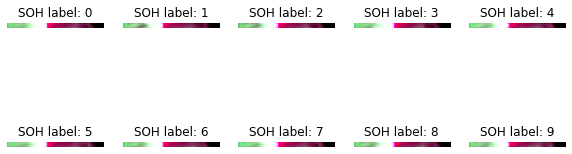

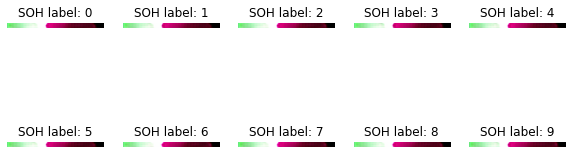

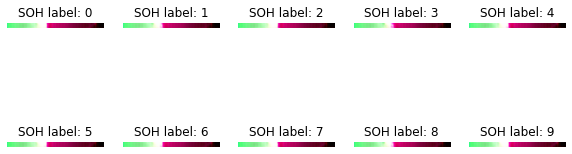

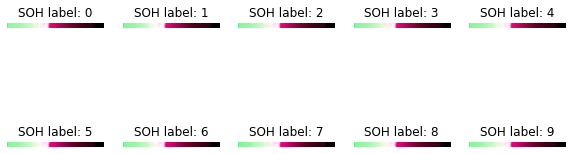

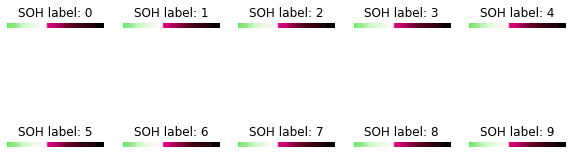

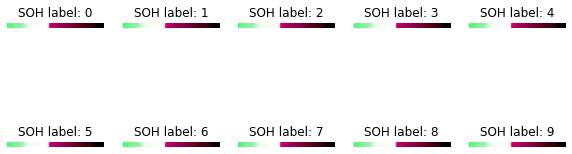

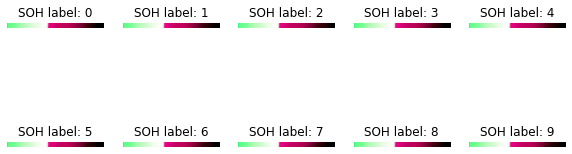

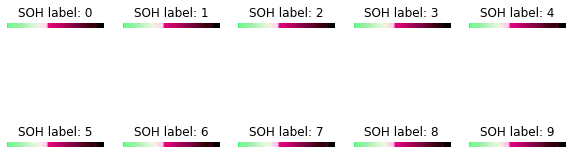

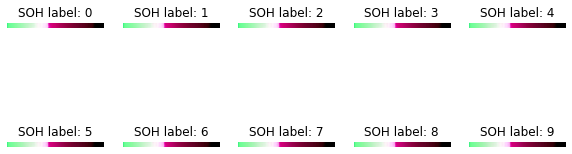

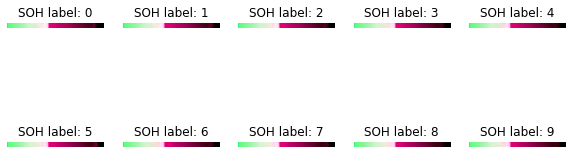

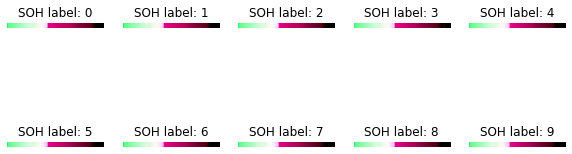

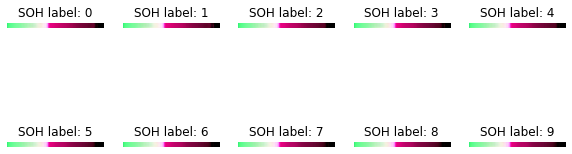

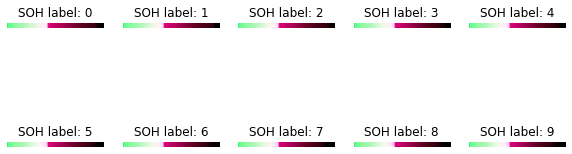

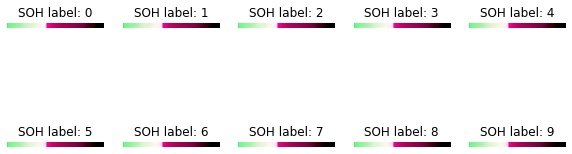

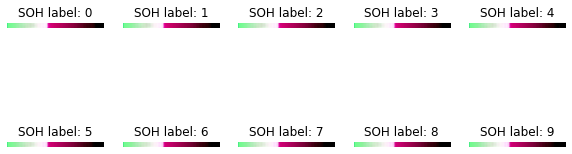

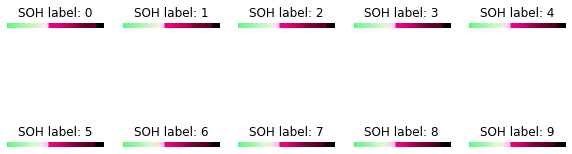

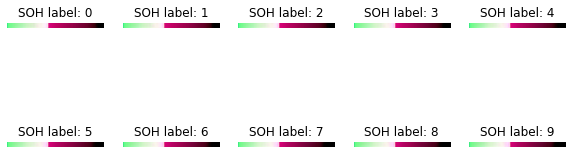

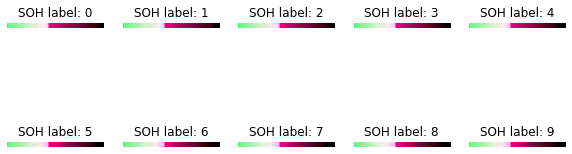

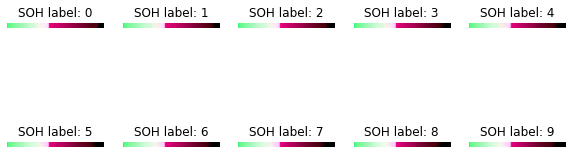

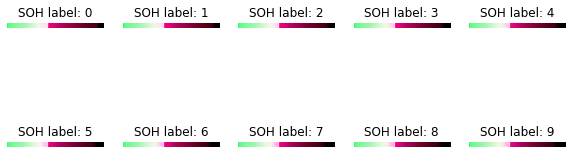

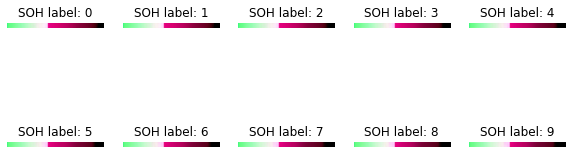

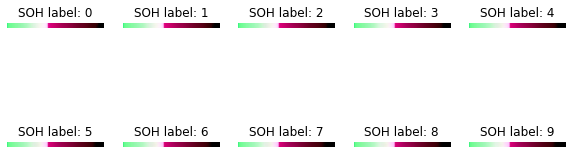

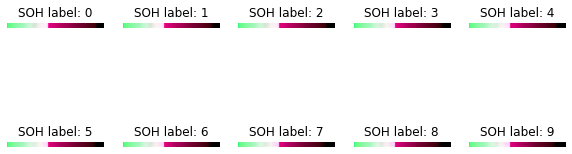

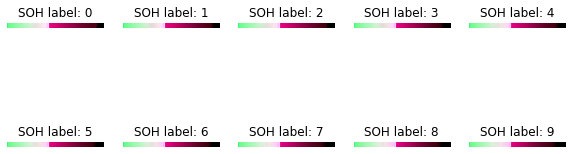

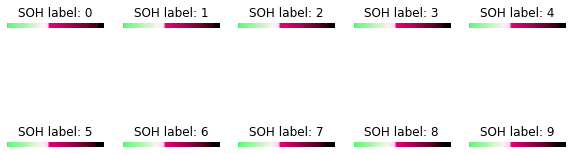

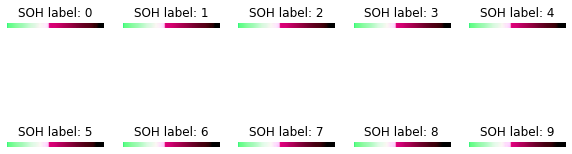

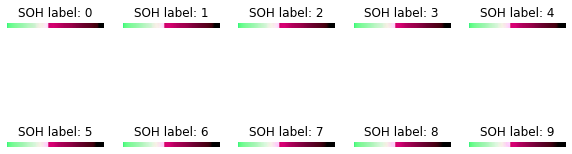

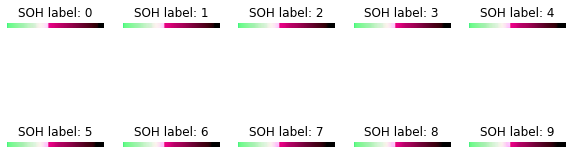

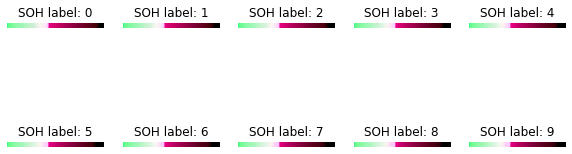

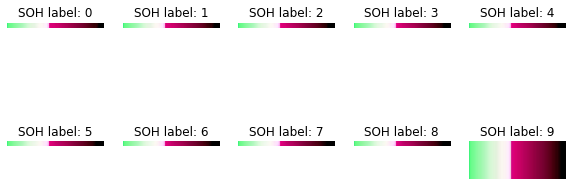

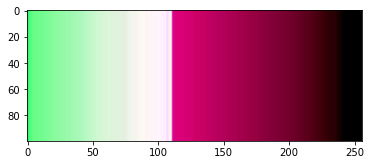

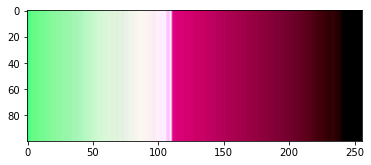

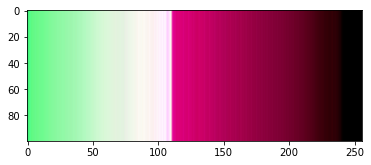

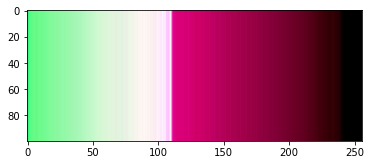

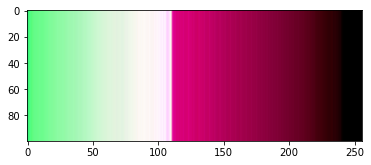

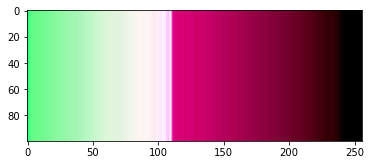

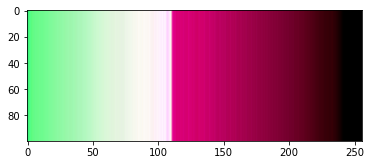

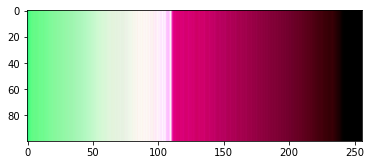

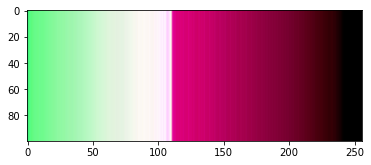

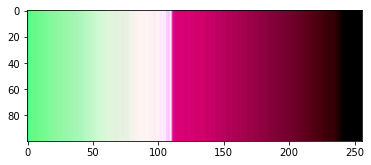

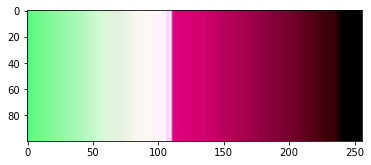

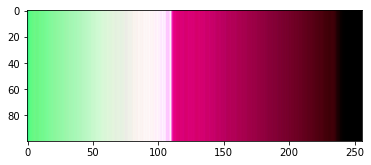

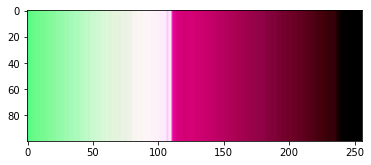

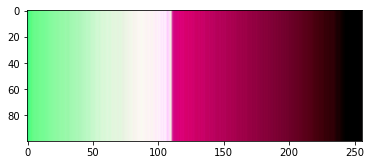

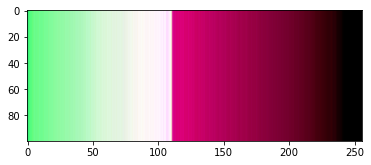

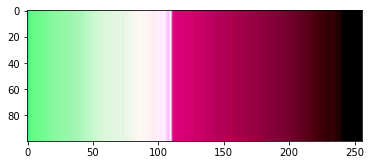

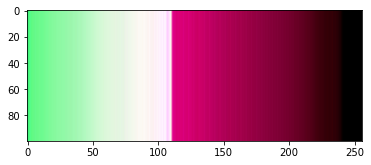

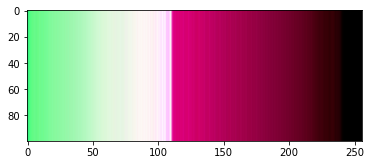

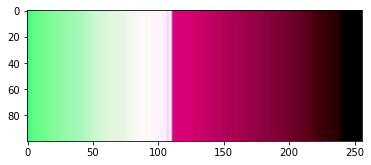

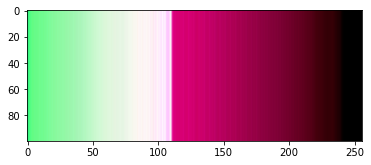

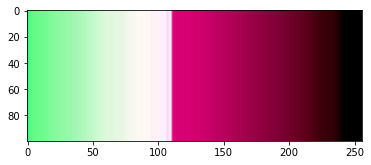

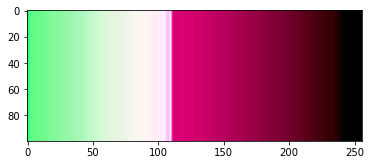

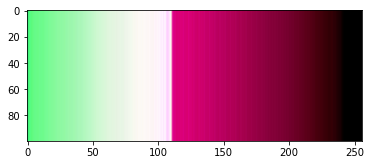

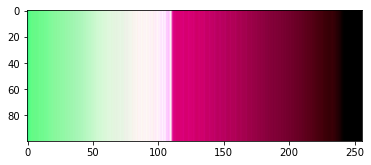

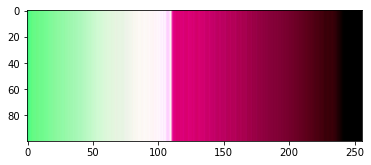

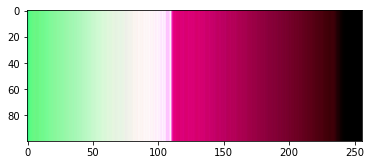

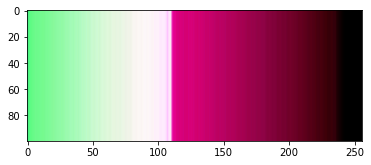

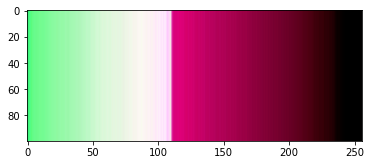

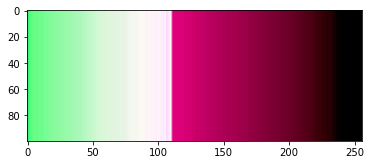

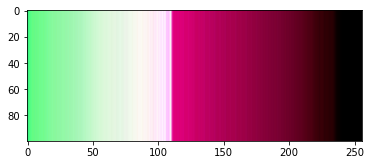

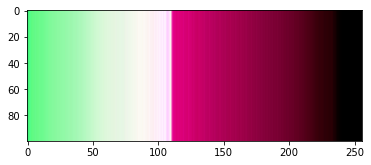

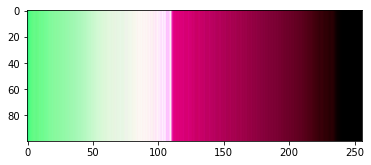

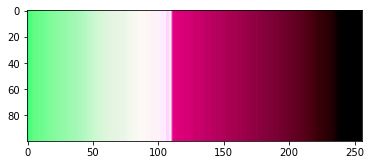

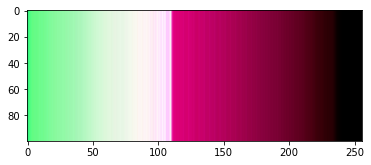

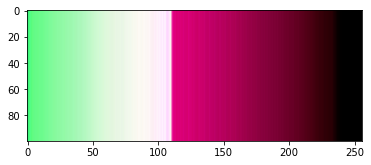

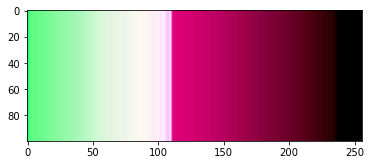

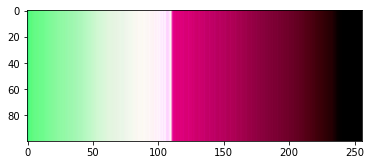

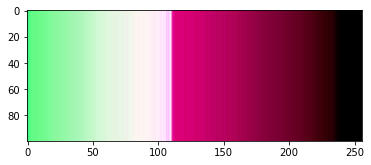

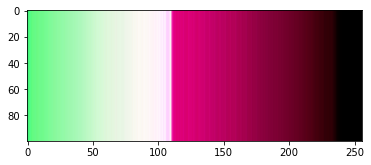

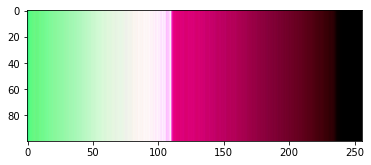

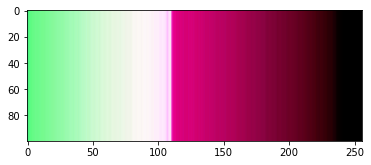

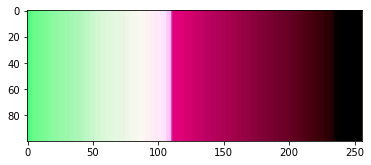

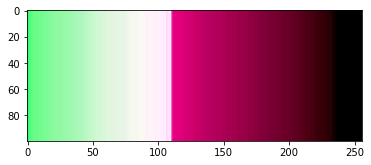

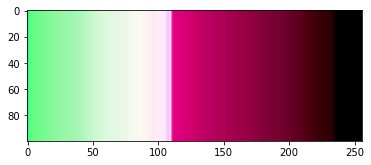

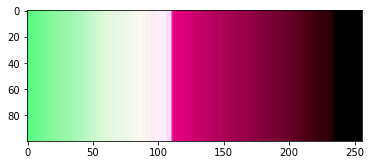

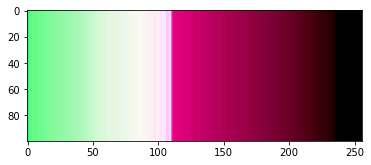

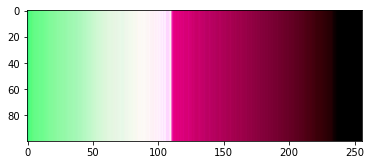

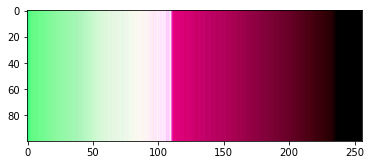

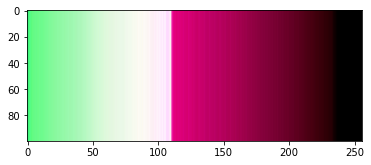

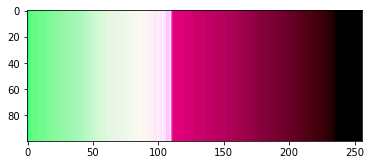

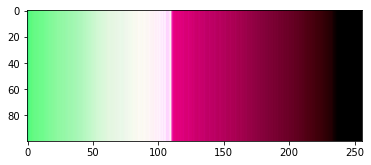

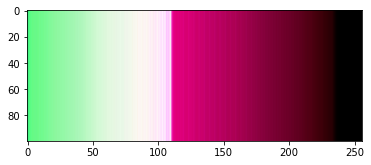

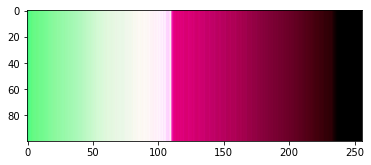

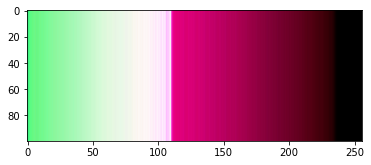

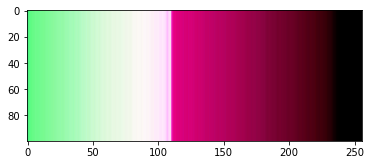

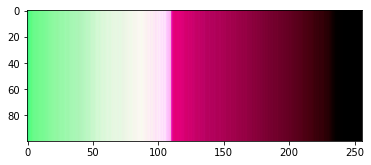

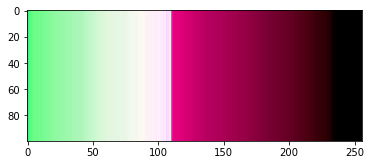

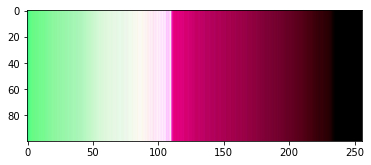

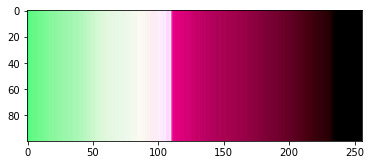

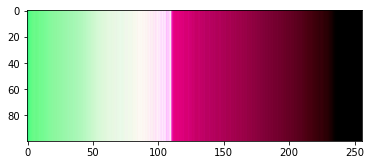

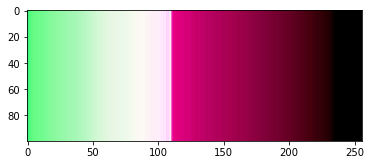

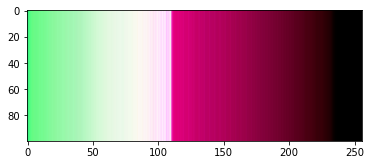

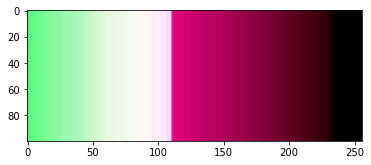

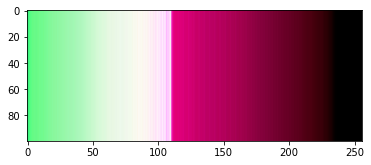

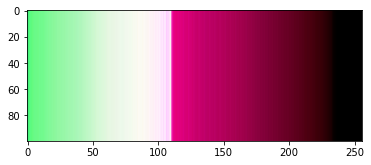

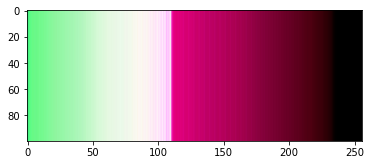

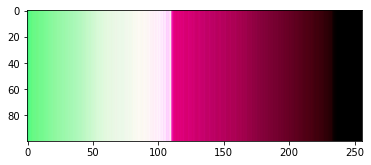

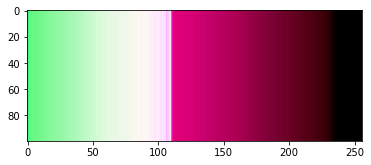

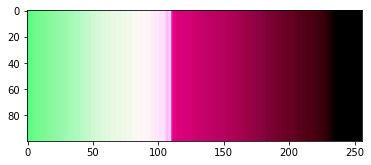

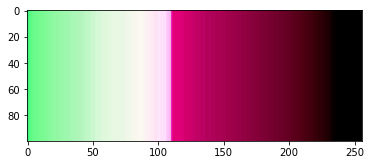

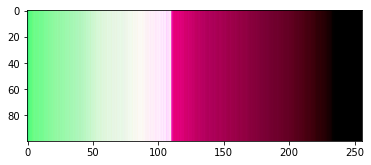

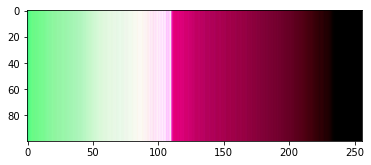

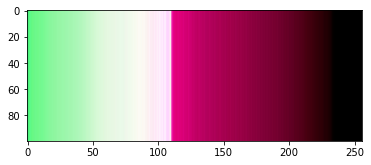

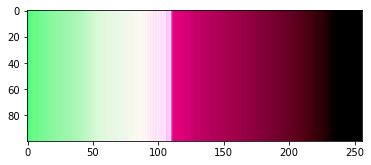

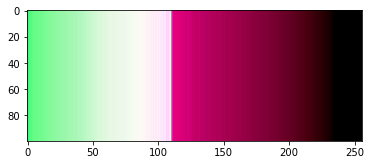

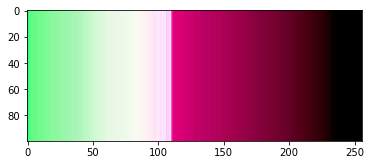

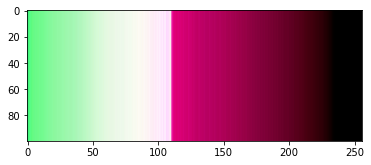

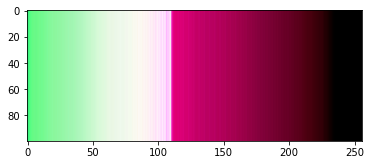

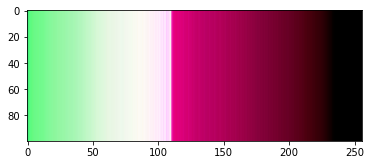

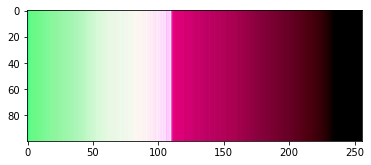

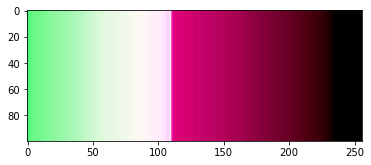

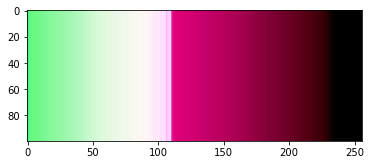

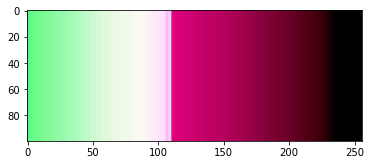

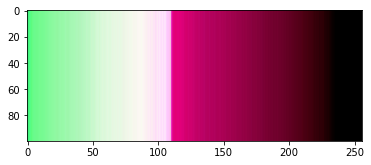

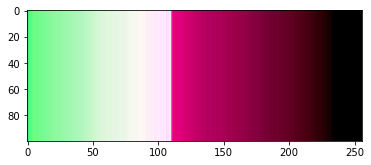

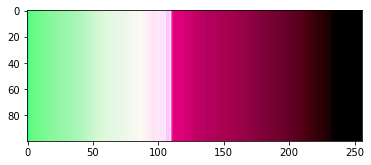

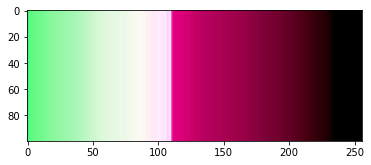

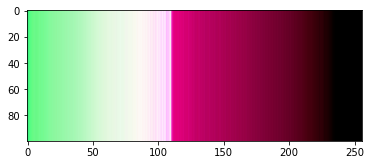

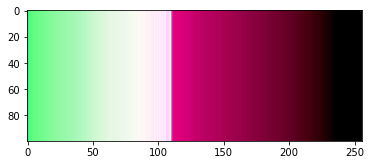

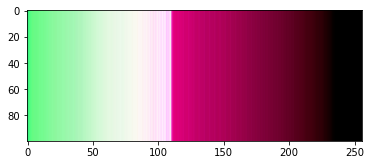

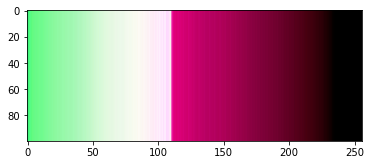

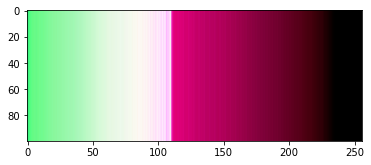

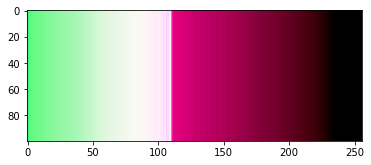

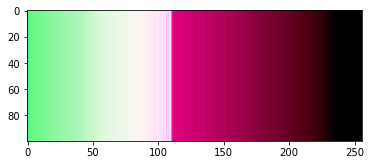

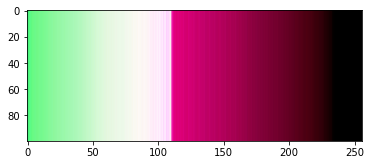

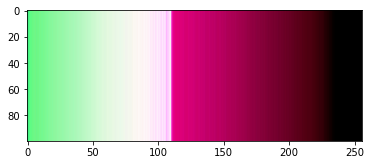

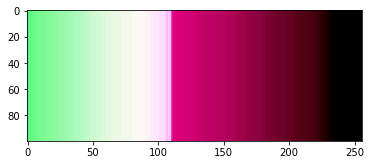

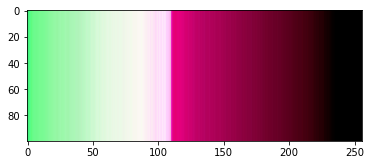

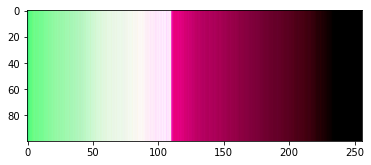

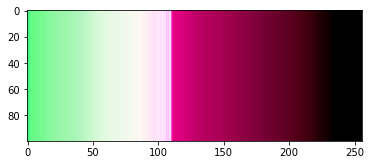

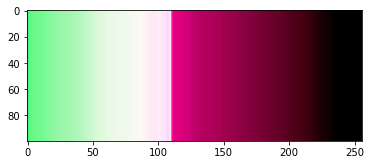

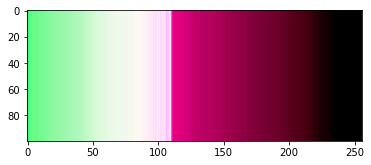

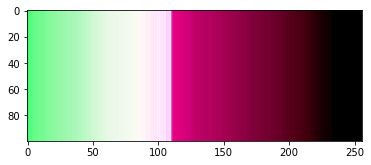

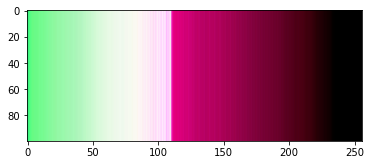

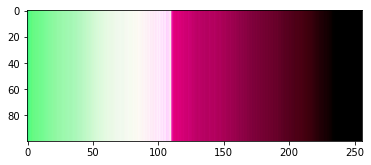

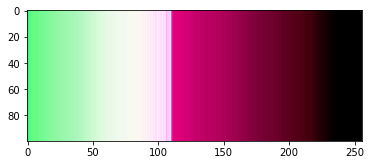

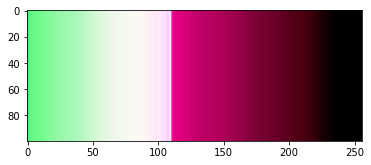

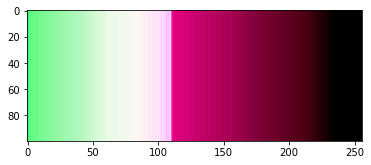

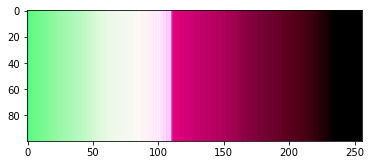

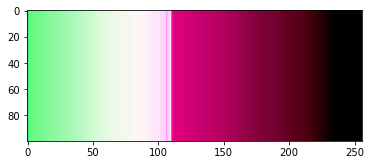

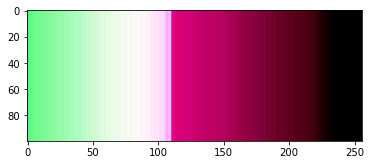

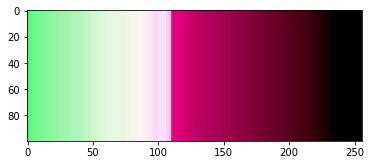

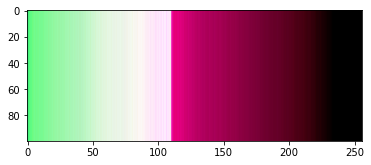

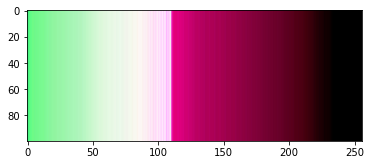

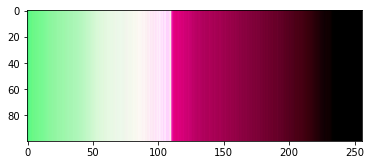

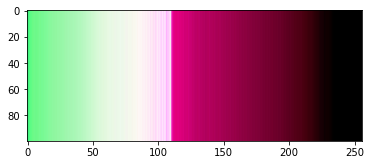

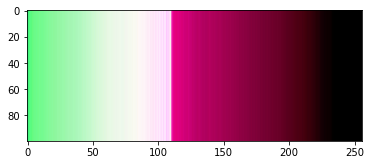

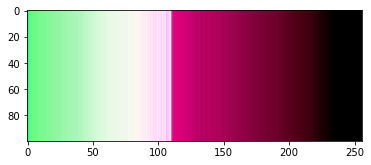

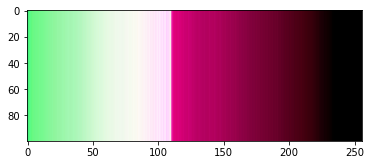

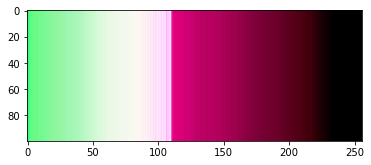

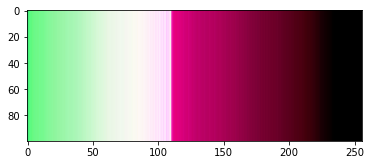

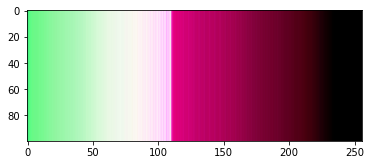

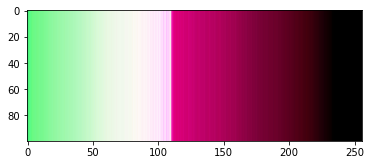

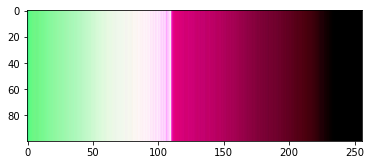

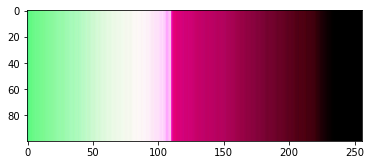

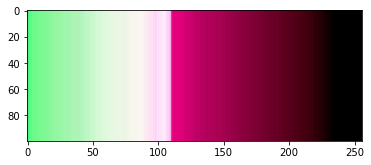

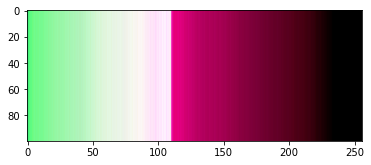

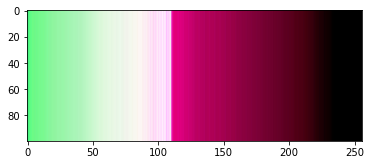

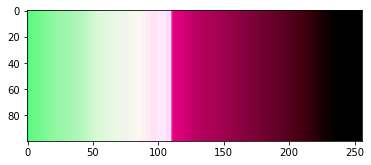

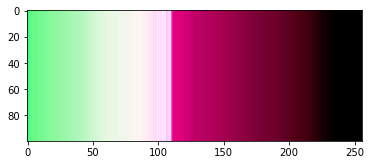

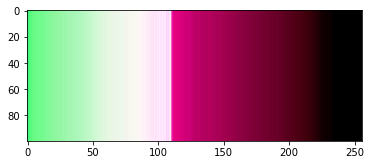

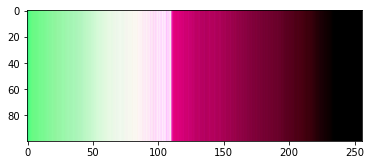

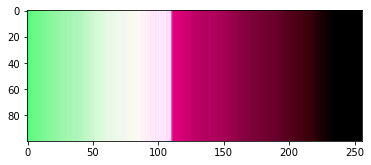

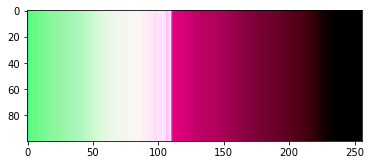

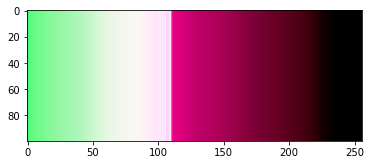

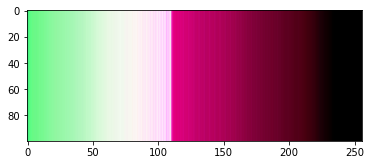

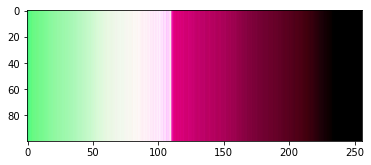

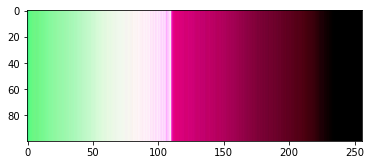

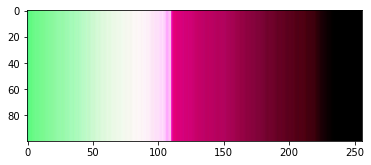

In [53]:
iterations = 3000
batch_size = 128

sample_interval = 100

train(X_train = X, y_train = np.array(label_l),iterations = iterations, batch_size = batch_size, sample_interval = sample_interval)

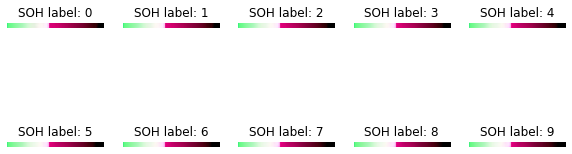

In [79]:
gen_img = sample_images()
gen_test = gen_img.reshape(10*14,256,3)*255
gen_test = np.array(gen_test, dtype = np.int16)


result = []
for i in range(len(gen_test)):
    result.append(gen_test[i])

    
df = pd.DataFrame({})
df['resized_scaled'] = result

## Interpolation cgan

In [80]:
re = np.array(result)
re = re.reshape(re.shape[0], 256, 3, 1)

re= re.astype('float32') /255.0

In [81]:
def result_images(a):

    z = np.random.normal(0, 1, (1, z_dim))

    labels = np.array([a]).reshape(-1,1)
    gen_imgs = generator.predict([z, labels])
    gen_imgs = 0.5 * gen_imgs + 0.5
    return gen_imgs

In [75]:
scaler = MinMaxScaler()
d_module = pd.read_csv('/home/sbml/cgan/230306_data/padding/module_preprocessed.csv')[['resized_scaled','soh']]
d_pack = pd.read_csv('/home/sbml/cgan/230306_data/padding/pack_preprocessed.csv')[['resized_scaled','soh']]


pack_soh = d_pack['soh'][10:]
pack_soh = [1/i for i in pack_soh]
pack_soh = scaler.fit_transform(np.array(pack_soh).reshape(-1,1)).reshape(1,-1).tolist()[0]
soh = [i*9 for i in pack_soh]

In [84]:
m = load_model('/home/sbml/cgan/230306_data/padding/cnn.h5')

In [85]:
module_soh = d_module['soh'].tolist()[140:]
result_soh = []
for i in soh:
    result = result_images(i)
    result = result.reshape(1*14,256,3)*255
    result = np.array(result, dtype = np.int16)
    re = np.array(result)
    re = re.reshape(re.shape[0], 256, 3, 1)
    re= re.astype('float32') /255.0
    y_predict = m.predict(re)
    result_soh = result_soh + y_predict[:,0].tolist()

<Figure size 720x720 with 0 Axes>

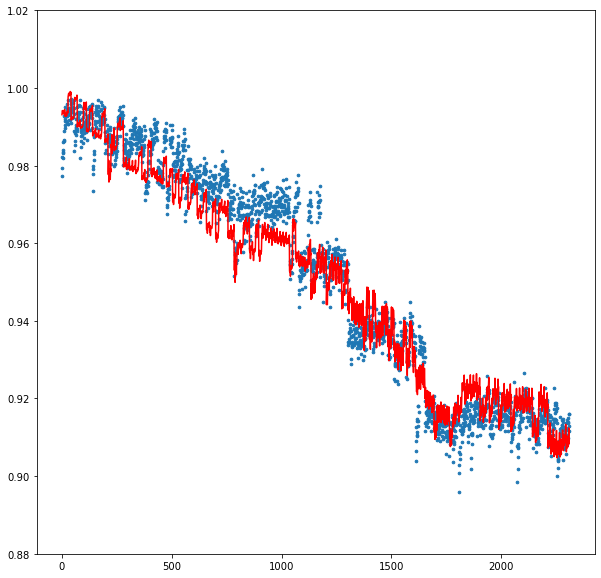

In [87]:
plt.figure(figsize = (10,10))

plt.plot(module_soh, c = 'red')
plt.scatter([i for i in range(len(result_soh))], result_soh, s = 7)

plt.ylim(0.88,1.02)
#plt.savefig('/home/sbml/cgan/230306_data/figure/fig4_result/module_raw_estimated_after_gan_result4.svg')